In [1]:
data_files = [
    '/dls/i06-1/data/2024/mm34159-2/i06-1-339089.nxs',
    '/dls/i06-1/data/2024/mm34159-2/i06-1-339090.nxs',
    '/dls/i06-1/data/2024/mm34159-2/i06-1-339091.nxs',
    '/dls/i06-1/data/2024/mm34159-2/i06-1-339092.nxs',
]

sim_data = {
    'ion': 'Cu',  # Ion Name
    'ch': 2,  # Charge
    'beta': 0.8,  # Beta
    'dq': 1.0,  # 10Dq
    'mag_field': (0, 0, 0),
    'exchange_field': (0, 0, 0.1),
    'temperature': 1.0,  # T (K)
}

# XAS Simulation Comparison
### Using Quanty

In [2]:
%matplotlib ipympl
%autosave 60

! module load quanty  # specifies the Quanty location
#! pip install --upgrade hdfmap

import os
import numpy as np
import matplotlib.pyplot as plt

import ipywidgets as widgets
from IPython.display import display, Markdown, Latex

from xas_simulator.simulation import create_simulation
from xas_simulator.beamline_data_loader import display_scans, get_scan_paths, Experiment
from xas_simulator.xmcd_analysis import calculate_xmcd, compare_spectra

import hdfmap
hdfmap.set_all_logging_level('error')

Autosaving every 60 seconds
Loading quanty/2024_autumn
  Loading requirement: global/directories
Writable TEMPDIR = /tmp


/scratch/grp66007/python/xas-simulator/xas_simulator/nexpy_nb_runner.py:99: SyntaxWarning: invalid escape sequence '\d'
  regex = spec.replace('%d', '(\d+)')


In [3]:
print('--- I06-1 Data ---')
print(display_scans(data_files))

# Analyse data
energy_path, signal_path, monitor_path, pol_path = get_scan_paths(data_files[0])
av_energy, interp_pc, interp_nc, diff = calculate_xmcd(data_files, energy_path, signal_path, pol_path, monitor_path)

--- I06-1 Data ---
i06-1-339089.nxs pol=pc, T=270.0K, B=   6.0T, scan fastEnergy 0.0 249.0 1.0 fesData 0 1
i06-1-339090.nxs pol=pc, T=270.0K, B=   6.0T, scan fastEnergy 0.0 249.0 1.0 fesData 0 1
i06-1-339091.nxs pol=nc, T=270.0K, B=   6.0T, scan fastEnergy 0.0 249.0 1.0 fesData 0 1
i06-1-339092.nxs pol=nc, T=270.0K, B=   6.0T, scan fastEnergy 0.0 249.0 1.0 fesData 0 1


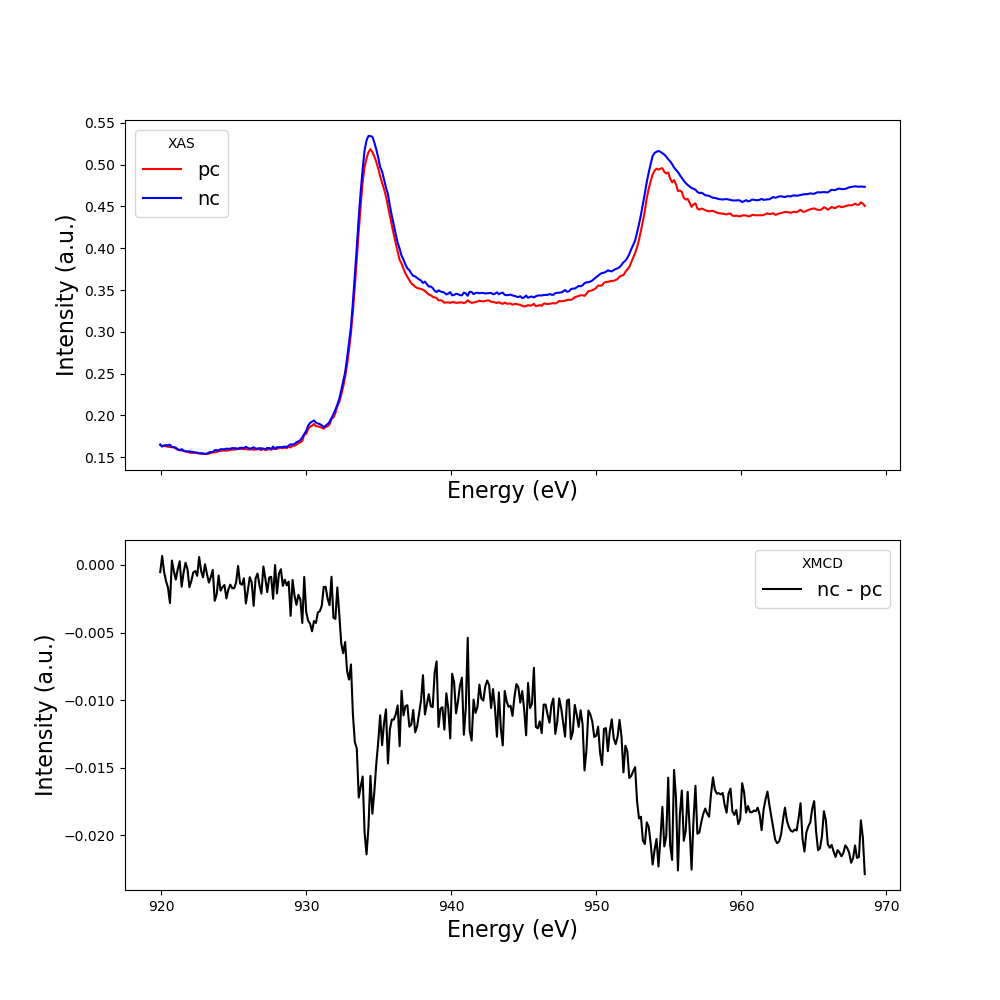

In [7]:
# Plot data
fig, ax = plt.subplots(2, sharex=True, figsize=(10, 10))

ax[0].plot(av_energy, interp_pc, '-r', label='pc')
ax[0].plot(av_energy, interp_nc, '-b', label='nc')
ax[0].legend(fontsize=14, title='XAS')
ax[0].set_ylabel('Intensity (a.u.)', fontsize=16)
ax[0].set_xlabel('Energy (eV)', fontsize=16)

ax[1].plot(av_energy, diff, '-k', label='pc - nc')
ax[1].legend(fontsize=14, title='XMCD')
ax[1].set_ylabel('Intensity (a.u.)', fontsize=16)
ax[1].set_xlabel('Energy (eV)', fontsize=16)

plt.show()

In [9]:
# Create and run Quanty Simulation
simulation = create_simulation(**sim_data)
output = simulation.run_all_with_output()
print(simulation.result.stdout)

3d9 2p5,3d10


FileNotFoundError: [Errno 2] No such file or directory: 'Quanty'

1025 1025
Theoretical values (Quanty):


L$_z$,S$_{eff}$,S$_{z}$,T$_{z}$
-0.3758,-0.7484,-0.4963,-0.2521


Sum rules :


sL$_z$,sS$_{eff}$
0.282943,-1.0208


Sum rules 0:


s$_0$L$_z$,s$_0$S$_{eff}$
0.251622,-0.907799


Deviations:


$\Delta$XAS (%),$\Delta$L$_{z}$ (%),$\Delta$S$_{eff}$ (%),$\Delta_0$L$_{z}$ (%),$\Delta_0$S$_{eff}$ (%)
24.8956,-24.7091,36.3977,-33.0437,21.2987


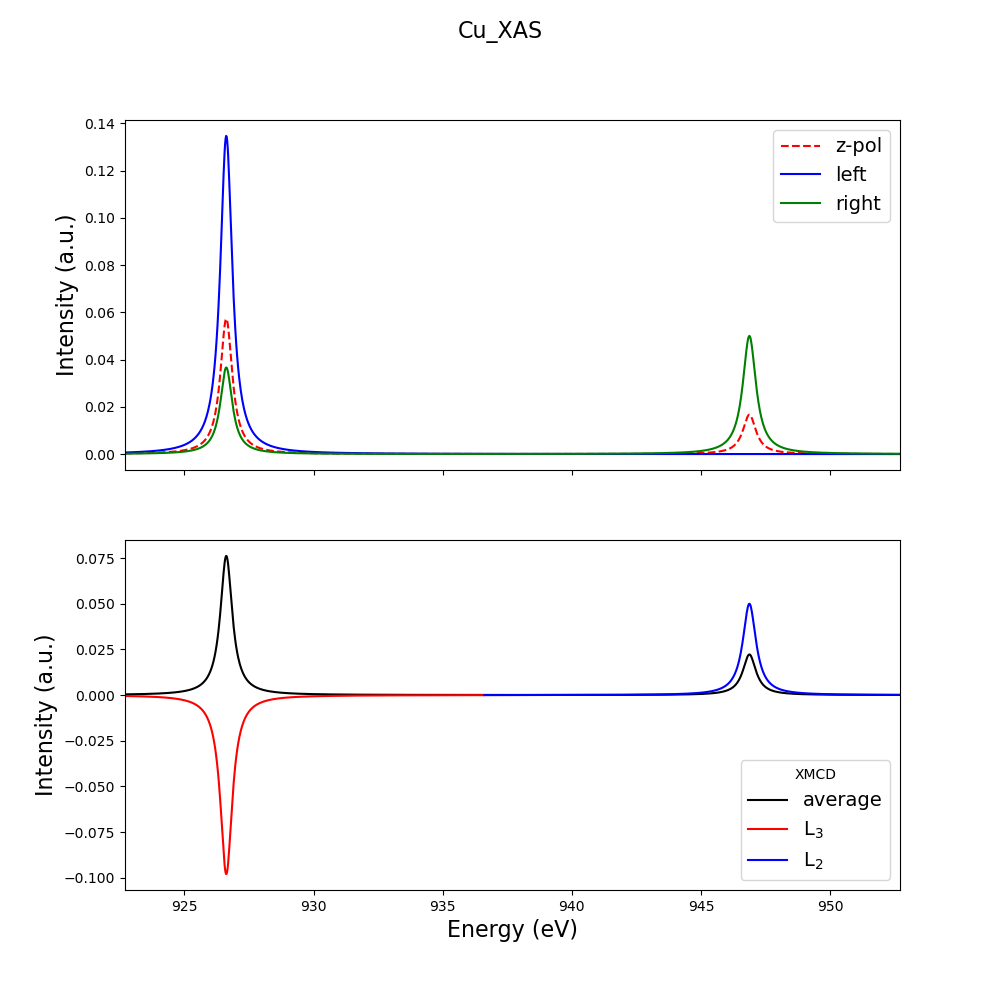

In [6]:
simulation.post_proc()

In [8]:
# Guess offset
simulation_max = output['xas_left_energy'][np.argmax(output['xas_left'])]
experiment_max = av_energy[np.argmax(interp_pc)]
ini_offset = experiment_max - simulation_max
print(f"Offset = {ini_offset:.2f} eV")

NameError: name 'output' is not defined

In [7]:
def change_offset(offset=ini_offset):
    fig, ax = plt.subplots(2, sharex=True, figsize=(10, 10))
    fig.suptitle(f"{simulation.ion} XAS")
    
    left = output['xas_left'] * max(interp_nc) / max(output['xas_left'])
    right = output['xas_right'] * max(interp_pc) / max(output['xas_left'])
    xmcd = output['xmcd'] * max(diff) / max(output['xmcd'])
    
    ax[0].plot(av_energy, interp_pc, '-r', label='pc')
    ax[0].plot(av_energy, interp_nc, '-b', label='nc')
    ax[0].plot(output['xas_left_energy'] + offset, left, ':r', label='sim. left')
    ax[0].plot(output['xas_right_energy'] + offset, right, ':b', label='sim. right')
    ax[0].legend(fontsize=14, title='XAS')
    ax[0].set_ylabel('Intensity (a.u.)', fontsize=16)
    ax[0].set_xlabel('Energy (eV)', fontsize=16)
    
    ax[1].plot(av_energy, diff, '-k', label='pc - nc')
    ax[1].plot(output['xmcd_energy'] + offset, xmcd, ':k', label='simulation')
    ax[1].legend(fontsize=14, title='XMCD')
    ax[1].set_ylabel('Intensity (a.u.)', fontsize=16)
    ax[1].set_xlabel('Energy (eV)', fontsize=16)
    
    plt.show()


widgets.interact(change_offset, offset=(ini_offset - 10.0, ini_offset + 10.0));

interactive(children=(FloatSlider(value=0.0, description='offset', max=10.0, min=-10.0), Output()), _dom_class…

<function __main__.change_offset(offset=0.0)>

In [9]:
exp = Experiment(os.path.dirname(data_files[0]))
files = exp.all_files()
print(len(files))

1176


In [10]:
widgets.interact(exp.read_scan, filename=[os.path.basename(file) for file in data_files]);

interactive(children=(Dropdown(description='filename', options=('i06-1-339089.nxs', 'i06-1-339090.nxs', 'i06-1…